# Introduction

This is the main code for using and importing the additional layers used in computing the ROI for the given cells.

## Commonly Used CNN Layers in PyTorch

This table summarizes some commonly used convolutional neural network (CNN) layers in PyTorch:

| Layer | Description | Python Code |
|---|---|---|
| Conv2d | Applies a 2D convolution over an input with multiple channels. | `nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, ...)` |
| ConvTranspose2d | Applies a 2D transposed convolution (deconvolution) over an input with multiple channels. | `nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, ...)` |
| MaxPool2d | Performs 2D max pooling over an input with multiple channels. | `nn.MaxPool2d(kernel_size, stride=None, padding=0, ...)` |
| AvgPool2d | Performs 2D average pooling over an input with multiple channels. | `nn.AvgPool2d(kernel_size, stride=None, padding=0, ...)` |
| AdaptiveMaxPool2d | Applies a 2D adaptive max pooling over an input. | `nn.AdaptiveMaxPool2d(output_size)` |
| AdaptiveAvgPool2d | Applies a 2D adaptive average pooling over an input. | `nn.AdaptiveAvgPool2d(output_size)` |
| BatchNorm2d | Applies Batch Normalization over a 4D input (mini-batch of 2D inputs with channels). | `nn.BatchNorm2d(num_features)` |
| GroupNorm | Applies Group Normalization over a mini-batch of inputs. | `nn.GroupNorm(num_groups, num_channels)` |
| InstanceNorm2d | Applies Instance Normalization over a 4D input. | `nn.InstanceNorm2d(num_features, ...)` |
| LayerNorm | Applies Layer Normalization over a mini-batch of inputs. | `nn.LayerNorm(normalized_shape)` |
| Dropout2d | Applies Dropout over a 4D input. | `nn.Dropout2d(p=0.5, ...)` |
| ReLU | Applies the rectified linear unit (ReLU) function element-wise. | `nn.ReLU(inplace=False)` |
| LeakyReLU | Applies the leaky rectified linear unit (LeakyReLU) function element-wise. | `nn.LeakyReLU(negative_slope=0.01, inplace=False)` |
| ELU | Applies the exponential linear unit (ELU) function element-wise. | `nn.ELU(alpha=1.0, inplace=False)` |
| SELU | Applies the scaled exponential linear unit (SELU) function element-wise. | `nn.SELU(inplace=False)` |
| Sigmoid | Applies the sigmoid function element-wise. | `nn.Sigmoid()` |
| Tanh | Applies the hyperbolic tangent (tanh) function element-wise. | `nn.Tanh()` |
| Softmax | Applies the Softmax function to an n-dimensional input tensor. | `nn.Softmax(dim=None)` |
| LogSoftmax | Applies the LogSoftmax function to an n-dimensional input tensor. | `nn.LogSoftmax(dim=None)` |
| Upsample | Upsamples a given multi-channel 2D (spatial) data. | `nn.Upsample(size=None, scale_factor=None, mode='nearest', ...)`

This is not an exhaustive list, but it covers many fundamental layers used in CNN architectures.


In [1]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


if torch.cuda.is_available():
    # Get the number of available GPUs
    gpu_count = torch.cuda.device_count()
    print(f"Number of available GPUs: {gpu_count}")

    # Iterate over each GPU and display its properties
    for i in range(gpu_count):
        gpu_properties = torch.cuda.get_device_properties(i)
        print(f"GPU {i} Properties:")
        print(f"\tName: {gpu_properties.name}")
        print(f"\tTotal Memory: {gpu_properties.total_memory / 1024**3:.2f} GB")
        print(f"\tCUDA Capability: {gpu_properties.major}.{gpu_properties.minor}")
        print(f"\tMulti-Processor Count: {gpu_properties.multi_processor_count}")
else:
    print("No GPU available, using CPU instead.")


Number of available GPUs: 1
GPU 0 Properties:
	Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU
	Total Memory: 8.00 GB
	CUDA Capability: 8.6
	Multi-Processor Count: 46


In [2]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """Convolution to produce final output"""
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits



In [3]:

model = UNet(n_channels=3, n_classes=1)

print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

## Creatig a custom Data Loader for our training images


In [4]:

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

# Example transformations
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


train_image_dir = "../datasets/DRIVE/training/images"
train_mask_dir = "../datasets/DRIVE/training/mask"
    
test_image_dir = "../datasets/DRIVE/test/images"
test_mask_dir = "../datasets/DRIVE/test/mask"

val_image_dir = "../datasets/DRIVE/test/images"
val_mask_dir = "../datasets/DRIVE/test/mask"

def set_image_path(train_image_dir,train_mask_dir,test_image_dir,test_mask_dir ,val_image_dir,val_mask_dir, include_val=False):
    
    if include_val:
        # Train dataset
        train_dataset = SegmentationDataset(image_dir=train_image_dir, mask_dir=train_mask_dir, transform=data_transforms)
        # Val Dataset
        val_dataset = SegmentationDataset(image_dir=val_image_dir, mask_dir=val_mask_dir, transform=data_transforms)
        # Test dataset
        test_dataset = SegmentationDataset(image_dir=test_image_dir, mask_dir=test_mask_dir, transform=data_transforms)
        
        train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

        for images, masks in train_loader:
            print(images.shape, masks.shape)
            break
        return train_loader, test_loader, val_loader
        
    else:
        # Train dataset:
        train_dataset = SegmentationDataset(image_dir=train_image_dir, mask_dir=train_mask_dir, transform=data_transforms)
        #val_dataset = SegmentationDataset(image_dir="path/to/val/images", mask_dir="path/to/val/masks", transform=data_transforms)
        #b Test dataset
        test_dataset = SegmentationDataset(image_dir=test_image_dir, mask_dir=test_mask_dir, transform=data_transforms)
        
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        #val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
        
    
        for images, masks in train_loader:
            print(images.shape, masks.shape)
            break
        return train_loader, test_loader
train_loader , test_loader = set_image_path(train_image_dir,train_mask_dir,test_image_dir,test_mask_dir,val_image_dir,val_mask_dir,False)

torch.Size([16, 3, 256, 256]) torch.Size([16, 1, 256, 256])


### Check first 6 images

In [12]:
# Function to plot images and masks
def plot_images_and_masks(images, masks, predictions, num_examples=6,save_path=None):
    plt.figure(figsize=(18, num_examples * 4))
    for i in range(num_examples):
        image = images[i].permute(1, 2, 0).numpy()
        mask = masks[i].squeeze().numpy()
        pred = predictions[i].squeeze().detach().numpy()

        plt.subplot(num_examples, 3, 3 * i + 1)
        plt.imshow(image)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(num_examples, 3, 3 * i + 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(num_examples, 3, 3 * i + 3)
        plt.imshow(pred, cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()


In [6]:
train_image_dir = "../datasets/DIC-C2DH-HeLa/01/train"
train_mask_dir = "../datasets/DIC-C2DH-HeLa/01_ERR_SEG/train"
    
test_image_dir = "../datasets/DIC-C2DH-HeLa/01/test"
test_mask_dir = "../datasets/DIC-C2DH-HeLa/01_ERR_SEG/test"

val_image_dir = "../datasets/DIC-C2DH-HeLa/01/valid"
val_mask_dir = "../datasets/DIC-C2DH-HeLa/01_ERR_SEG/valid"

train_loader, test_loader, val_loader = set_image_path(train_image_dir,train_mask_dir,test_image_dir,test_mask_dir,val_image_dir,val_mask_dir,True)

torch.Size([10, 3, 256, 256]) torch.Size([10, 1, 256, 256])


### Train Validation and Test


In [7]:
# Training loop (simplified)
gpu_id = 0
device = torch.device(f'cuda:{gpu_id}' if torch.cuda.is_available() else 'cpu')
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

#### Training Phase



In [8]:
# Assuming you have defined a loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store metrics
train_losses = []
val_losses = []
# Training loop
num_epochs = 100
# # Fetch a batch of data and run through the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images, val_masks = val_images.to(device), val_masks.to(device)
            
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_masks)
            
            val_running_loss += val_loss.item() * val_images.size(0)
    
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_epoch_loss)
    
    if (epoch-1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Save training metrics to disk
np.save('train_losses.npy', train_losses)
# Save validation metrics to disk
np.save('validation_losses.npy', val_losses)


Epoch [2/100], Loss: 0.4019
Epoch [12/100], Loss: 0.1489
Epoch [22/100], Loss: 0.0929
Epoch [32/100], Loss: 0.0709
Epoch [42/100], Loss: 0.0608
Epoch [52/100], Loss: 0.0556
Epoch [62/100], Loss: 0.0527
Epoch [72/100], Loss: 0.0509
Epoch [82/100], Loss: 0.0498
Epoch [92/100], Loss: 0.0490


#### Validation Phase

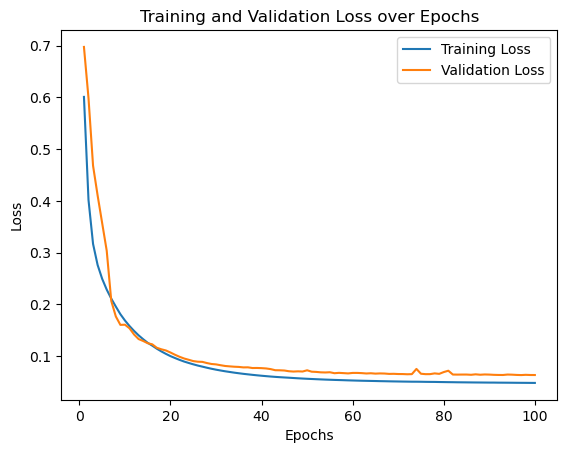

In [9]:
# Plot metrics
plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

#### Testing

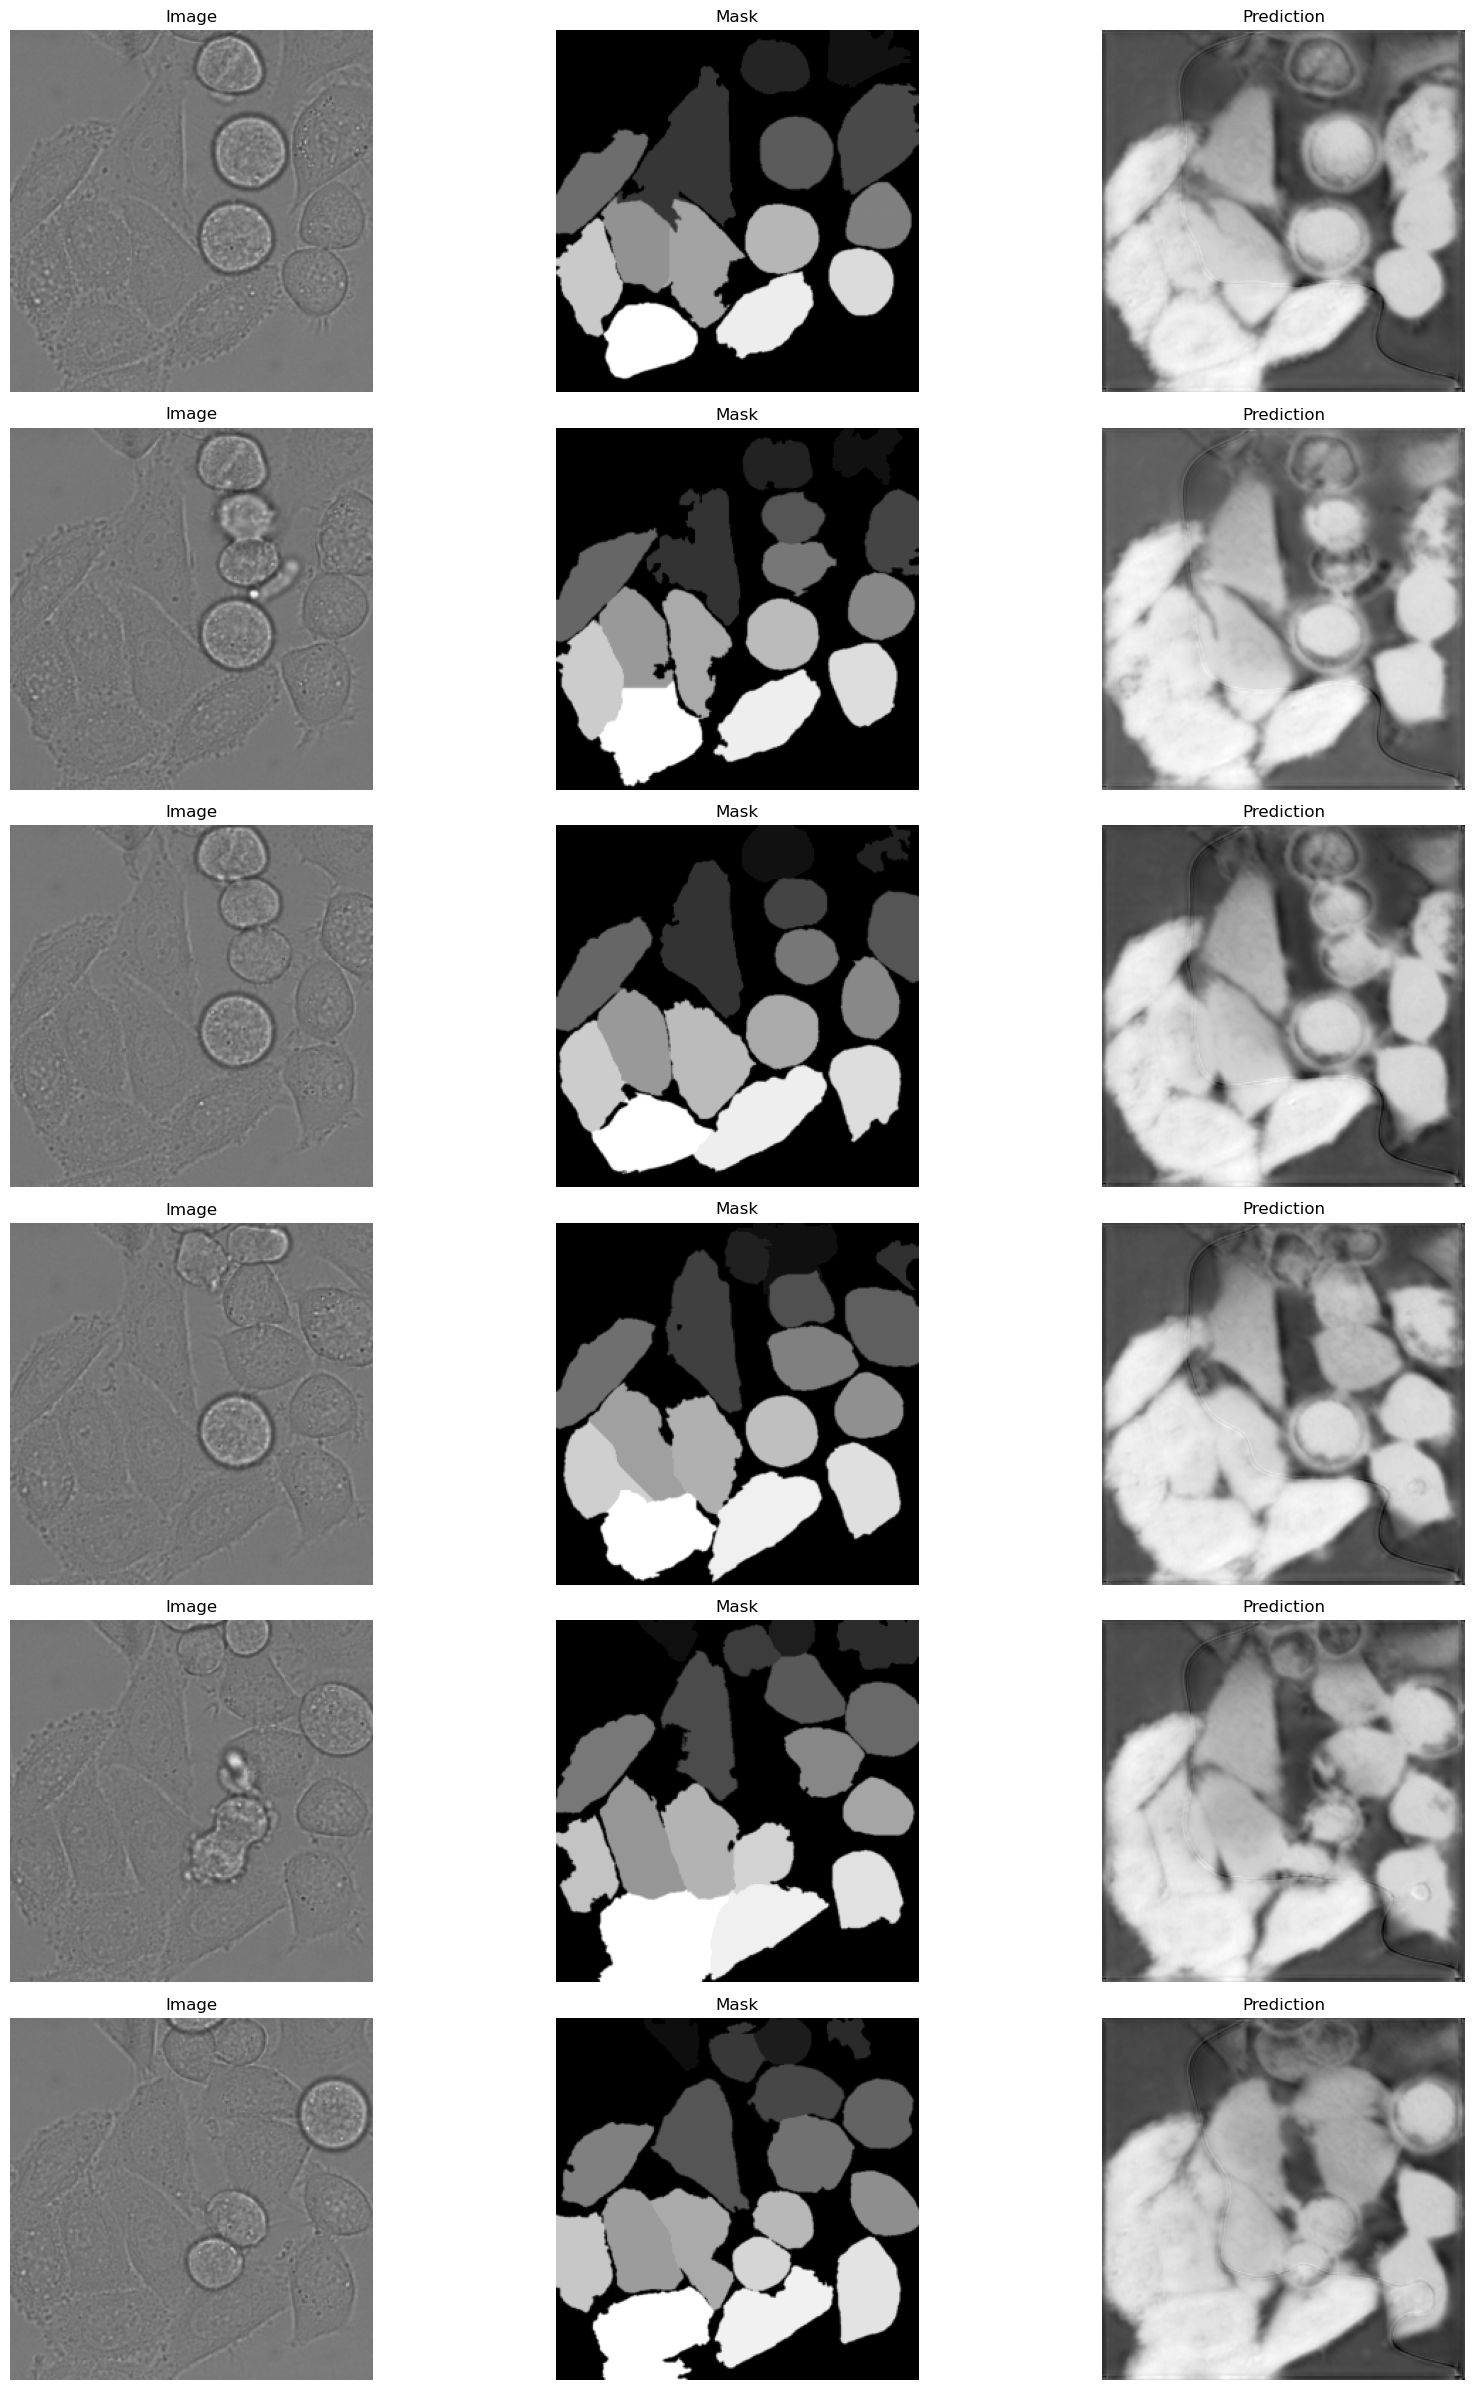

In [15]:
# Optionally, plot some test images and predictions
def plot_test_predictions(model, test_loader, device, num_examples=6,path=None):
    model.eval()
    with torch.no_grad():
        for i, (images, masks) in enumerate(test_loader):
            if i >= num_examples:
                break
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)

            images = images.cpu()
            masks = masks.cpu()
            outputs = outputs.cpu()

            plot_images_and_masks(images, masks, outputs, num_examples=num_examples,save_path=path)
            break  # Plot only one batch for demonstration purposes
save_path = 'test_predictions.png'
nr_examples = 6
plot_test_predictions(model, test_loader, device, nr_examples,save_path)